# Yelp Sentiment Analysis with doc2vec Document Vectors

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/packt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pathlib import Path
import logging
from random import shuffle

import numpy as np
import pandas as pd

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from nltk import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.utils import class_weight

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### Settings

In [4]:
sns.set_style('white')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

### Paths

In [5]:
data_path = Path('..', 'data', 'yelp')

In [6]:
results_path = Path('results', 'yelp')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Logging Config

In [7]:
logging.basicConfig(
        filename=results_path / 'doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

Refer to download information [here](../data/create_yelp_review_data.ipynb).

We'll create a smaller sample of 100,000 reviews per star rating.

In [8]:
df = pd.read_parquet(data_path / 'user_reviews.parquet').loc[:, ['stars', 'text']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8021122 entries, 0 to 8021121
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   stars   float64
 1   text    object 
dtypes: float64(1), object(1)
memory usage: 183.6+ MB


In [10]:
df.stars.value_counts()

5.0    3586460
4.0    1673404
1.0    1283897
3.0     842289
2.0     635072
Name: stars, dtype: int64

In [11]:
stars = range(1, 6)

In [12]:
sample = pd.concat([df[df.stars == s].sample(n=100000) for s in stars])

In [13]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 7812276 to 4618307
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stars   500000 non-null  float64
 1   text    500000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.4+ MB


In [14]:
sample.stars.value_counts()

3.0    100000
5.0    100000
4.0    100000
2.0    100000
1.0    100000
Name: stars, dtype: int64

In [15]:
sample.to_parquet(results_path / 'review_sample.parquet')

In [16]:
sample = pd.read_parquet(results_path / 'review_sample.parquet').reset_index(drop=True)

In [17]:
sample.head()

,stars,text
0,1.0,I have worked with Peter at Green Arrow for a...
1,1.0,Worst salon ever!!!! They make an appointment ...
2,1.0,could be happenin' if anybody showed up. pitt...
3,1.0,"Yeah, so nothing has changed with their servic..."
4,1.0,I sent a parts request through their online em...


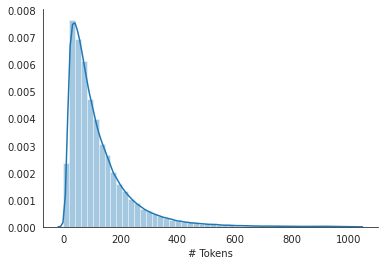

In [18]:
ax = sns.distplot(sample.text.str.split().str.len())
ax.set_xlabel('# Tokens')
sns.despine();